# Introductory EDA

The purpose of this notebook is to give a brief, high-level overview of our dataset as well as some of the tools of NLP.

# Setup

In [2]:
from toxic import common

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

%xmode plain
%matplotlib inline
# sns.set_style('darkgrid')

from IPython.display import display

from collections import OrderedDict
from sklearn.neighbors import LocalOutlierFactor

from toxic.common.data import get_kaggle_data

Exception reporting mode: Plain


# The Data

In [3]:
train = get_kaggle_data('train', verbose=True)
test = get_kaggle_data('test', verbose=True)

In [22]:
ratings = train.loc[:, 'toxic':'identity_hate']
raw_comments = train['comment_text']
train['is_toxic'] = train.loc[:, 'toxic':].any(axis=1)

** Look at train and test data: **

In [29]:
display(train.head())
print('Train: {:,} comments'.format(train.shape[0]))
print()
display(test.head())
print('Test: {:,} comments'.format(test.shape[0]))

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic
id,,,,,,,,
00054a5e18b50dd4,bbq \r\n\r\nbe a man and lets discuss it-maybe...,0,0,0,0,0,0,False
0010833a96e1f886,"""== A barnstar for you! ==\r\n\r\n The Real L...",0,0,0,0,0,0,False
002a13f2896596fa,"""\r\n\r\nOppose – As the article stands, it do...",0,0,0,0,0,0,False
0038f191ffc93d75,Transliteration of Russian place names\r\nIn w...,0,0,0,0,0,0,False
004b073d5b456b15,"""\r\n Czech Republic is in Central Europe. The...",0,0,0,0,0,0,False


Train: 159,571 comments



,comment_text
id,
0027c21bc4637efd,I was merely apologising for my interference ;)
003260a50813dba9,== hrthrtdghrsdtghtrsdhtrhdgthjrtgh == \r\n\r\...
003e3cb0578f451e,""" \r\n ::People don't need to be sent messages..."
0070c68c9a05a502,""" \r\n ==Brothers== \r\n The List of associati..."
00768ff5e3f93322,"Stop vandalizing the Sheryl Swoopes article, o..."


Test: 153,164 comments


Previously, we had just under 96,000 training records, and 227,000 test records. Now we have more equal numbers, **159,571** and **153,164**, respectively.

** Wayyyy more normal than toxic comments: **

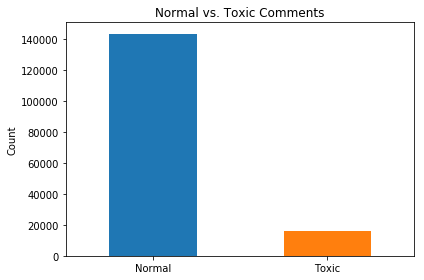

In [27]:
# Toxic vs. nontoxic
ax = train['is_toxic'].value_counts().plot(kind='bar')
ax.set_title('Normal vs. Toxic Comments')
ax.set_ylabel('Count')
ax.xaxis.set_ticklabels(['Normal', 'Toxic'], )
[tick.set_rotation(0) for tick in ax.get_xticklabels()]
plt.tight_layout()

** Mostly toxic, obscene, insults: **

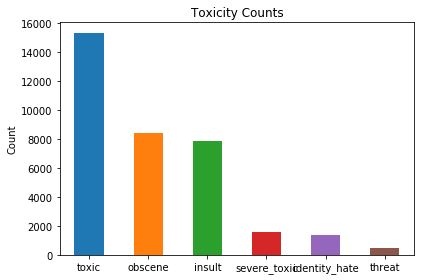

In [25]:
# Toxicity counts
ax = (ratings.sum(axis=0)
      .sort_values(ascending=False)
      .plot(kind='bar', title='Toxicity Counts'))
ax.set_ylabel('Count')
[tick.set_rotation(0) for tick in ax.get_xticklabels()]
plt.tight_layout()

** The top toxicities are all correlated: **

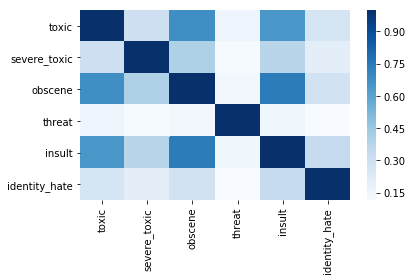

In [26]:
# Correlation heatmap
sns.heatmap(ratings.corr(), cmap='Blues')
plt.tight_layout()

In [9]:
ratings.corr().round(2)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.00,0.31,0.68,0.16,0.65,0.27
severe_toxic,0.31,1.00,0.40,0.12,0.38,0.20
obscene,0.68,0.40,1.00,0.14,0.74,0.29
threat,0.16,0.12,0.14,1.00,0.15,0.12
insult,0.65,0.38,0.74,0.15,1.00,0.34
identity_hate,0.27,0.20,0.29,0.12,0.34,1.00


Based on the above, there seems to a be a **strong dimension of obscene, toxic insults** in these comments data.... But note: threats are very rare and not correlated with anything else.

Before going any further, let's take a look at a handful of comments:

# Illustrative Records and Wordclouds

In [10]:
from pprint import pprint
illustrations = train['comment_text'].sample(5, random_state=10)
for i in illustrations:
    print(i)
    print('='*80)

A byte (octet) is the usual unit of digital storage and can represent the integers 0 to 255 but not 256. Simple bit shifting is not enough to divide accurately by 256 because the least significant bit needs special treatment if you hope for accuracy.
Seventeenth Amendment to the United States Constitution 

I removed the text from the Federal Senate's site on direct election since I couldn't find a copyright/PD notice on their site (However I didn't look TOO far) and I think direct appropriation is frowned upon, however I don't know about the last point.
Added Celts back in 

I added celts back in since it is a reliable source.
You don't get to defend yourself with personal attacks, nor do edits earn you any sort of 'bad behavior credits'.
Personal Attack 

http://en.wikipedia.org/w/index.php?title=Kumdo&diff;=250246779&oldid;=250235822

Did you really real reference? 'Kumdo'  word found by Old Chinese book. And Kumdo orginization officially state that it word and skills originate from

>Okay, so first pass impression...some people get really angry on the internet. But seriously, of the above five, three are what I would classify as toxic. The first is obscene and threatening, the third is racist and obscene, and the fourth may also be racist but at least seems to target someone personally. The second is scathing, but not toxic, and the last is nearly gibberish.
> Notice: The first user spams the same message repeatedly, which is something that many toxic commenters could conceivably do.

We don't seem to be getting as many obviously toxic comments with the new data set, most of these are now tame.

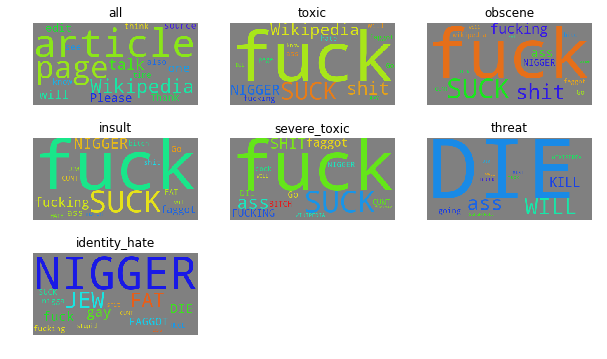

In [13]:
cloud = WordCloud(
    random_state=42, 
    min_font_size=10, 
    max_words=15, 
    background_color='gray', 
    prefer_horizontal=.999, 
    font_step=2, 
    relative_scaling=1)

plot_dict = OrderedDict([
    ('all',' '.join(train['comment_text'])),
    ('toxic',' '.join(train['comment_text'][train['toxic'] == 1])),
    ('obscene',' '.join(train.comment_text[train['obscene'] == 1])),
    ('insult',' '.join(train.comment_text[train['insult'] == 1])),
    ('severe_toxic',' '.join(train.comment_text[train['severe_toxic'] == 1])),
    ('threat',' '.join(train.comment_text[train['threat'] == 1])),
    ('identity_hate',' '.join(train.comment_text[train['identity_hate'] == 1])),
])

fig = plt.figure(1, figsize=(10,6))

for i,title in enumerate(plot_dict):
    ax = plt.subplot(int(str(33) + str(i + 1)))
    common.plotting.plot_wordcloud_to_axis(plot_dict[title], title, ax, cloud_obj=cloud)

plt.show()

# Text Vectorization

The function `vectorize_text` below is a wrapper for two sklearn classes that transform a corpus (comments) into a term-document matrix.

In [31]:
common.preprocessing.vectorize_text??

Signature: common.preprocessing.vectorize_text(corpus=None, output='sparse', vect='count', param_dict={'stop_words': 'english', 'binary': False, 'ngram_range': (1, 1), 'max_features': 1000})
Source:   
def vectorize_text(
    corpus=None, 
    output='sparse',
    vect='count',
    param_dict=dict(
        ngram_range=(1,1),
        stop_words='english',
        max_features=1000,
        binary=False
    )
):
    """
    Helper function to vectorize raw comments in introduction.ipynb.
    Fits and transforms either a CountVectorizer ('count') or
    TfidfVectorizer ('tfidf') to a corpus of comments and returns
    a DataFrame with appropriately-labeled axes.    
    """
    if not isinstance(corpus, _pandas.Series):
        raise ValueError('Enter a Pandas Series object for corpus')
    
    if vect == 'count':
        vectorizer = _sklearn.feature_extraction.text.CountVectorizer(**param_dict)
    elif vect == 'tfidf':
        vectorizer = _sklearn.feature_extraction.text.TfidfVectori

In [14]:
params = dict(
    ngram_range=(1,2),
    stop_words='english',
    max_features=1000,
    binary=False
)

counts = common.preprocessing.vectorize_text(raw_comments, output='df', vect='count', param_dict=params)

Fitting data...
Transforming data...
Sorting df cols...
Done


In [15]:
counts.head()

,article,wikipedia,page,talk,like,just,don,think,know,people,...,indian,discussion page,moment,btw,shut,required,earth,damn,ga,hitler
id,,,,,,,,,,,,,,,,,,,,,
00054a5e18b50dd4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0010833a96e1f886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
002a13f2896596fa,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0038f191ffc93d75,0,2,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
004b073d5b456b15,3,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


** Top words focus on articles, wikipedia: **

In [16]:
counts.sum(axis=0).sort_values(ascending=False).head()

article      57661
wikipedia    48427
page         46460
talk         37094
like         28008
dtype: int64